# Practical Bayesian Tomography: Supplemental Material<br/>Animations #

[Christopher Granade](http://www.cgranade.com), Joshua Combes and D. G. Cory

## Preamble

In [1]:
from __future__ import division
%matplotlib inline

In [2]:
import numpy as np
import qutip as qt
import qinfer as qi
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [3]:
import tempfile as tf
import os

In [4]:
pallette = plt.rcParams['axes.color_cycle']
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 22

In [5]:
from qinfer.tomography.plotting_tools import (
    plot_cov_ellipse, plot_decorate_rebits, plot_rebit_modelparams, plot_rebit_prior, plot_rebit_posterior
)

In [6]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

## Diffusive Qubit Tomography ##

In [7]:
def diffusion_movie(n_steps=1000, save_stills=()):
    tempdir = tf.mkdtemp()
    print "Saving to {}.".format(tempdir)
    pbar = qt.ui.TextProgressBar()
    pbar.start(n_steps, chunk_size=1)
    
    basis = qi.tomography.pauli_basis(1)
    
    diffusive_model = qi.BinomialModel(qi.tomography.DiffusiveTomographyModel(basis, False))
    
    true_states = []
    est_states = []
    
    true_state = np.array([[1, 0.99, 0, 0, 0]]) / np.sqrt(2)
    true_state[0, -1] = 0.0045
    diffusive_prior = qi.ProductDistribution(
        qi.tomography.GADFLIDistribution(
            qi.tomography.GinibreReditDistribution(basis),
            I / 2 - 0.02 * Z / 2 + 0.88 * X / 2
        ),
        qi.LogNormalDistribution(0.0, 0.006)
    )
    
    updater = qi.smc.SMCUpdater(diffusive_model, 3000, diffusive_prior)
    heuristic = qi.tomography.RandomPauliHeuristic(updater, other_fields={'n_meas': 25, 't': 1})
    
    fig, (ax_rebit, ax_cov) = plt.subplots(1, 2, figsize=(1920 * 12 / 1080, 12))
    
    for idx_exp in xrange(n_steps):
        expparams = heuristic()
        outcome = diffusive_model.simulate_experiment(true_state, expparams)
        updater.update(outcome, expparams)
        
        est_states.append(basis.modelparams_to_state(updater.est_mean()[:-1]))
        true_states.append(basis.modelparams_to_state(true_state[0, :-1]))
        err = np.linalg.norm(true_state[0] - updater.est_mean(), 2)
        
        true_state = diffusive_model.update_timestep(true_state, expparams)[:, :, 0]
        
        plt.sca(ax_rebit)
        plot_rebit_posterior(updater, prior=None, true_state=true_state, rebit_axes=[1, 3], true_size=600)
        plt.xticks([-1, 0, 1], size=14)
        plt.yticks([-1, 0, 1], size=14)
        
        plt.sca(ax_cov)
        updater.plot_covariance(param_slice=np.s_[1:4], tick_params={'size': 20})
        
        plt.savefig(os.path.join(tempdir, '{:05}.png'.format(idx_exp)), dpi=1080 * 100 / 1200)
        if idx_exp in save_stills:
            plt.savefig(os.path.join(tempdir, '{:05}.pdf'.format(idx_exp)), dpi=1080 * 100 / 1200)
        ax_rebit.clear()
        ax_cov.clear()
        pbar.update(idx_exp)
        
    return true_states, est_states

Saving to /tmp/tmpCq3B7o.
 1.0%. Run time:  67.76s. Est. time left: 00:01:51:47
 2.0%. Run time: 131.56s. Est. time left: 00:01:47:26
 3.0%. Run time: 195.61s. Est. time left: 00:01:45:24
 4.0%. Run time: 263.44s. Est. time left: 00:01:45:22
 5.0%. Run time: 330.26s. Est. time left: 00:01:44:34
 6.0%. Run time: 397.35s. Est. time left: 00:01:43:45
 7.0%. Run time: 463.27s. Est. time left: 00:01:42:34
 8.0%. Run time: 527.75s. Est. time left: 00:01:41:09
 9.0%. Run time: 593.93s. Est. time left: 00:01:40:05
10.0%. Run time: 660.34s. Est. time left: 00:01:39:03
11.0%. Run time: 723.63s. Est. time left: 00:01:37:34
12.0%. Run time: 787.11s. Est. time left: 00:01:36:12
13.0%. Run time: 851.94s. Est. time left: 00:01:35:01
14.0%. Run time: 916.34s. Est. time left: 00:01:33:48
15.0%. Run time: 981.08s. Est. time left: 00:01:32:39
16.0%. Run time: 1045.72s. Est. time left: 00:01:31:30
17.0%. Run time: 1111.48s. Est. time left: 00:01:30:26
18.0%. Run time: 1176.59s. Est. time left: 00:01:29:20

/home/cgranade/anaconda/lib/python2.7/site-packages/qinfer/utils.py:109: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)


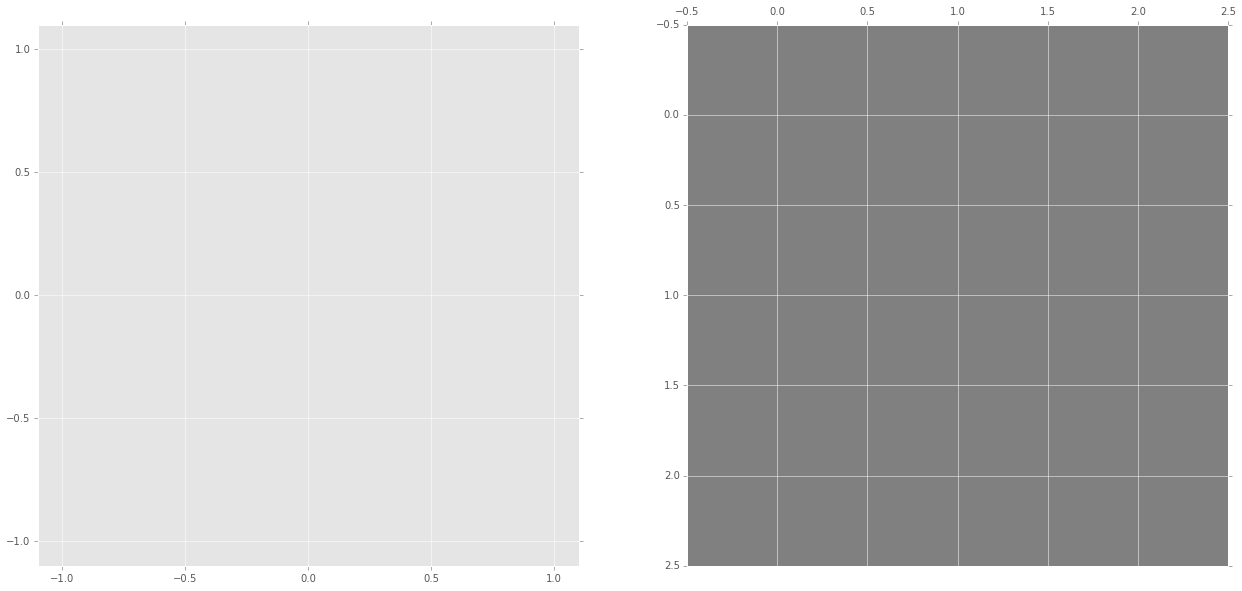

In [8]:
true_states, est_states = diffusion_movie(10000, save_stills=[1000 * idx for idx in xrange(1, 10)])

To compile these frames into a video, use ``ffmpeg``:
```
$ ffmpeg -framerate 30 -i %05d.png -c:v libx264 -r 30 -pix_fmt yuv420p out.mp4
```